In [1]:
%load_ext autoreload
%autoreload 2

import json
import math
import sys
import time
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
# genff imports
from genff.data_handling.dataset import GroupDataset
from genff.data_handling.transform import RectangularAngle
from genff.gan_method.networks import GenNet
from genff.mode_estimation.mode_estimation import find_modes
from genff.opt_method.opt_generator import opt_generator, opt_generator_loss, torch_to_numpy
from genff.visualization.plotting import plot_sample, plot_sample_rect

In [3]:
# bin imports
from bin.make_generated_data import load_environment, env_group, crop_env

In [4]:
def load_args(path):
    # save params
    with open(path, 'r') as fid:
        return json.load(fid)
    
    
def load_generator(model_folder: str, pt_name: str) -> torch.nn.Module:
    model_path = "../wgan_models/{}/{}".format(model_folder,pt_name)
    args_path = "../wgan_models/{}/args.txt".format(model_folder)
    args = load_args(args_path)
    generator = GenNet(args["grid_res"], int(args["grid_w"]), int(args["grid_w"]), bool(args["combine_env_channels"]), sigma=args["plot_sigma"])
    print(args)
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    generator.load_state_dict(checkpoint['generator_state_dict'])
    return generator

In [5]:
def generate_groups(generator, num_generated, group_data, env_data, crop_radius, x_index=0, y_index=1, theta_index=2, cos_index=2, sin_index=3, draw_result=False):
    # generator.to(torch.device('cuda'))
    generator.eval()
    transform = RectangularAngle(angle_index=2)

    with torch.no_grad():
        # Get number of pre-existing people in context
        context_people = len(group_data)

        # Preserve x,y,theta for real coordinates
        real_context = torch.zeros(1,context_people,3)
        real_context[:,:,:] = torch.tensor(group_data)
        real_center = torch.mean(real_context, dim=1)

        # Calculate centered data
        centered_context = torch.zeros(1,context_people,3)
        centered_context[:,:,theta_index] = real_context[:,:,theta_index]
        centered_context[:,:,[x_index, y_index]] = real_context[:,:,[x_index, y_index]] - \
                                                   real_center[:, [x_index,y_index]]
        centered_mask = torch.ones(1,context_people)
        centered_env = torch.tensor(crop_env(real_context.squeeze(0).numpy(), env_data, crop_radius)).unsqueeze(0)

        groups = []
        distros = []
        env_images = []
        exec_times = []
        distros.append(np.zeros((36,3)))
        
        groups.append(centered_context.clone().squeeze(0).numpy())
        env_images.append(centered_env.clone().squeeze(0).numpy())

        for i in range(num_generated):
            # Generate sample using centered data
            _, context, mask, env = transform((centered_context, centered_context, centered_mask, centered_env))
            dist_samples_lst = []

            start_time = time.time()
            for j in range(36): # 36 from optimization + WGAN distribution evaluations
                out = generator(context, mask, env)
                dist_samples_lst.append(out)

            dist_tensor = torch.cat(dist_samples_lst)
            dist_np = dist_tensor.squeeze(1).numpy()
            dist_samples = np.zeros((36, 3))
            dist_samples[:, 0:2] = dist_np[:, 0:2]
            dist_samples[:, 2] = np.arctan2(dist_np[:, 3], dist_np[:, 2])
                
            modes = find_modes(dist_samples, bandwidth=0.8, threshold=0.3, kappa=1.0)
            mode = np.zeros((1,4))
            mode[:,[0, 1]] = modes[0,0:2]
            mode[:,2] = np.cos(modes[0,2])
            mode[:,3] = np.sin(modes[0,2])
            new_ind = torch.from_numpy(mode).unsqueeze(0)
            new_ind = new_ind.type(torch.FloatTensor)
            end_time = time.time()
            exec_times.append(end_time - start_time)

            if draw_result:
                plt.figure()
                plot_sample_rect(dist_tensor.squeeze(1), context.squeeze(0), mask.squeeze(0), env_cropped=env[0],
                                 env_res=env_data["resolution"], plot_center=True)

            # Convert from 4-feature generator output to 3-feature for final data output
            num_features = context.shape[-1]
            centered_samples = torch.zeros((1, 1, num_features-1), device="cpu")
            centered_samples[:, 0, [x_index,y_index]] = new_ind[:, 0, [x_index,y_index]].cpu()
            centered_samples[:, 0, [theta_index]] = np.arctan2(new_ind[:, 0, [sin_index]].cpu(),
                                                               new_ind[:, 0, [cos_index]].cpu())
            # Calculate real coords in world
            real_center = torch.mean(real_context, dim=1)
            real_samples = centered_samples.clone()
            real_samples[:, 0, [x_index,y_index]] = real_samples[:, 0, [x_index,y_index]] + \
                                                    real_center[:, [x_index,y_index]]
            real_context = torch.cat((real_context, real_samples), dim=1)

            # Re-center centered data given new data point
            previous_center = real_center.clone()
            real_center = torch.mean(real_context, dim=1)

            # centered_context = torch.cat((centered_context, centered_samples), dim=1)
            centered_context = real_context.clone()
            centered_context[:, :, [x_index, y_index]] = real_context[:, :, [x_index, y_index]] - \
                                                         real_center[:, [x_index,y_index]]
            centered_mask = torch.cat((mask, torch.ones(1, 1)), dim=1)
            centered_env = crop_env(real_context.clone().squeeze(0).numpy(), env_data, crop_radius)
            env_images.append(centered_env)
            centered_env = torch.tensor(centered_env).unsqueeze(0)
            groups.append(centered_context.clone().squeeze(0).numpy())
            
            # center the distribution of generated poses
            centered_dist = torch.zeros((36,3))
            centered_dist[:, [x_index, y_index]] = (dist_tensor[:, 0, [x_index, y_index]] + previous_center[:, [x_index, y_index]]) - real_center[:, [x_index, y_index]]
            centered_dist[:, [theta_index]] = torch.atan2(dist_tensor[:, 0, [sin_index]].cpu(), dist_tensor[:, 0, [cos_index]].cpu())
            distros.append(centered_dist.clone().numpy())

            if draw_result:
                _, plot_context, plot_mask, plot_env = transform((centered_context, centered_context, centered_mask, centered_env))
                plt.figure()
                plot_sample_rect(None, plot_context.squeeze(0), plot_mask.squeeze(0), env_cropped=plot_env[0],
                                 env_res=env_data["resolution"], plot_center=True)

        return groups, distros, env_images, exec_times

In [6]:
model = load_generator('igibson', 'igibson.pt')

{'input_file': ['data/igibson_sim_data/env_Beechwood_0_int.h5', 'data/igibson_sim_data/env_Beechwood_0_int_warped.h5', 'data/igibson_sim_data/env_Beechwood_1_int.h5', 'data/igibson_sim_data/env_Beechwood_1_int_warped.h5', 'data/igibson_sim_data/env_Benevolence_0_int.h5', 'data/igibson_sim_data/env_Benevolence_1_int.h5', 'data/igibson_sim_data/env_Benevolence_1_int_warped.h5', 'data/igibson_sim_data/env_Benevolence_2_int.h5', 'data/igibson_sim_data/env_Benevolence_2_int_warped.h5', 'data/igibson_sim_data/env_Ihlen_0_int.h5', 'data/igibson_sim_data/env_Ihlen_0_int_warped.h5', 'data/igibson_sim_data/env_Ihlen_1_int.h5', 'data/igibson_sim_data/env_Ihlen_1_int_warped.h5', 'data/igibson_sim_data/env_Merom_0_int.h5', 'data/igibson_sim_data/env_Merom_0_int_warped.h5', 'data/igibson_sim_data/env_Merom_1_int.h5', 'data/igibson_sim_data/env_Merom_1_int_warped.h5', 'data/igibson_sim_data/env_Pomaria_0_int.h5', 'data/igibson_sim_data/env_Pomaria_0_int_warped.h5', 'data/igibson_sim_data/env_Pomaria_

In [7]:
cocktail_party_env = load_environment('../data/cocktail_party/env_cocktail_party.txt')
merom_env = load_environment('../data/igibson_maps/env_Merom_0_int.txt')
pomaria_env = load_environment('../data/igibson_maps/env_Pomaria_1_int.txt')

In [8]:
# env_group(people_lo, people_hi, r_range, personal_space, env, crop_radius)
cp_group, cp_env_data = env_group(1, 1, r_range=(0.8, 1.5), personal_space=1.0, env=cocktail_party_env, crop_radius=3.0)
merom_group, merom_env_data = env_group(1, 1, r_range=(0.8, 1.5), personal_space=1.0, env=merom_env, crop_radius=3.0)
pomaria_group, pomaria_env_data = env_group(1, 1, r_range=(0.8, 1.5), personal_space=1.0, env=pomaria_env, crop_radius=3.0)

## Cocktail Party Data simulated group

Looks OK with up to 6 total group individuals, less good with more than 6 (due to training data)

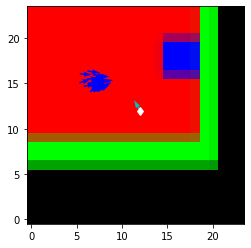

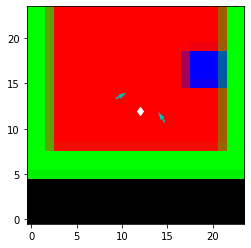

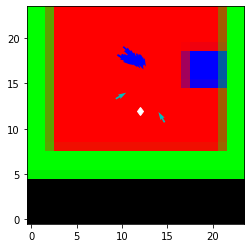

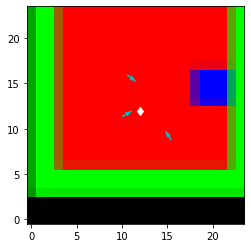

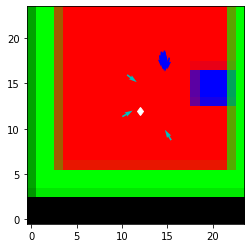

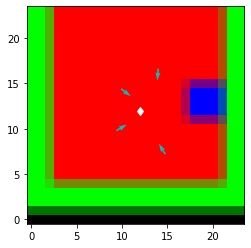

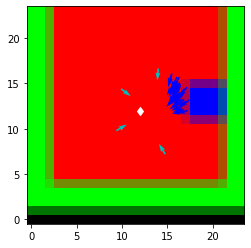

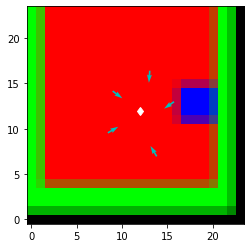

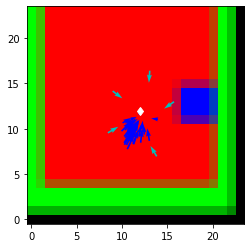

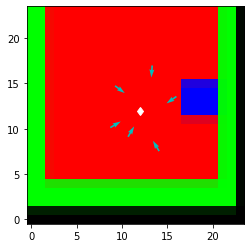

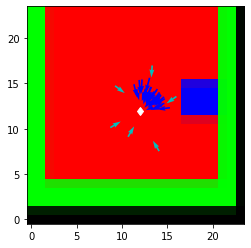

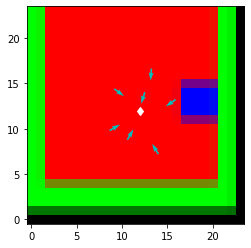

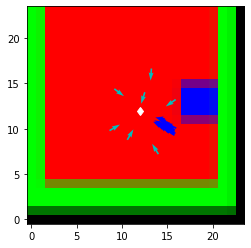

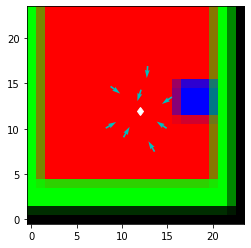

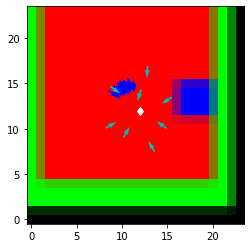

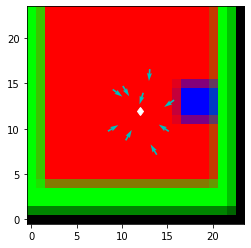

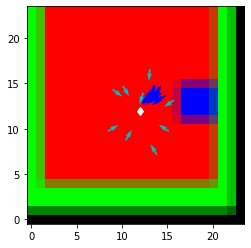

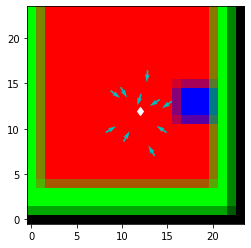

In [9]:
groups_gan, distros_gan, env_gan, exec_times_gan = generate_groups(model, 9, cp_group, cocktail_party_env, 3.0, draw_result=True)

In [10]:
print(exec_times_gan)

[0.0915677547454834, 0.08171701431274414, 0.07987093925476074, 0.08801388740539551, 0.08841490745544434, 0.08445215225219727, 0.08275890350341797, 0.08452677726745605, 0.09483718872070312]


# Optimization method iterative group generation

In [11]:
def opt_generate_groups(num_generated, group_data, env_data, crop_radius, x_index=0, y_index=1, theta_index=2, draw_result=False):
    # Get number of pre-existing people in context
    context_people = len(group_data)
    res = env_data['resolution']
    
    # Convert NumPy arrays to tensors
    real_context = torch.zeros(context_people,3)
    real_context[:,:] = torch.tensor(group_data)
    real_center = torch.mean(real_context, dim=0)

    # Calculate centered data
    context = torch.zeros(context_people,3)
    context[:,theta_index] = real_context[:,theta_index]
    context[:, [x_index, y_index]] = real_context[:,[x_index, y_index]] - real_center[[x_index,y_index]]

    mask = torch.ones(context_people)
    centered_env = torch.tensor(crop_env(real_context.numpy(), env_data, crop_radius))

    x = np.arange(-3, 3, 1.0)
    y = np.arange(-3, 3, 1.0)
    xv, yv = np.meshgrid(x, y)
    x0_arr= np.stack((xv.flatten(), yv.flatten()), axis=1)

    groups = []
    distros = []
    env_images = []
    exec_times = []
   
    groups.append(context.clone().numpy())
    env_images.append(centered_env.clone().squeeze(0).numpy())
    distros.append(np.zeros((36,3)))

    for i in range(num_generated):
        mask = torch.ones((context.shape[0]))
        start_time = time.time()
        opt_dist, final_losses, loss_fn = opt_generator(context, mask, centered_env, res, x0_arr, weight_psloss=1.25, weight_closs=0.2, weight_eloss=0.5)
        end_time = time.time()
        exec_times.append(end_time - start_time)
        
        opt_modes = find_modes(opt_dist, bandwidth=0.8, threshold=0.3, kappa=1.0)
        new_ind = torch.from_numpy(opt_modes[0]).unsqueeze(0)
        if draw_result:
            plt.figure()
            plot_sample(torch.from_numpy(opt_dist), context, mask, centered_env, res, plot_center=True)
        
        # add new_ind to working context
        context = torch.cat((context, new_ind))
        mask = torch.cat((mask, torch.ones(1)))
        
        # Calculate real coords in world        
        new_ind[:, [x_index,y_index]] = new_ind[:, [x_index,y_index]] + real_center[[x_index,y_index]]
        real_context = torch.cat((real_context, new_ind))

        # Re-center centered data given new data point
        previous_center = real_center.clone()
        real_center = torch.mean(real_context, dim=0)
        context = real_context.clone()
        context[:, [x_index, y_index]] = real_context[:, [x_index, y_index]] - real_center[[x_index,y_index]]

        opt_dist_tensor = torch.from_numpy(opt_dist)
        centered_dist = torch.zeros((36,3))
        centered_dist = centered_dist.type(torch.DoubleTensor)
        centered_dist[:,[x_index,y_index]] = (opt_dist_tensor[:,[x_index, y_index]] + previous_center[[x_index,y_index]]) - real_center[[x_index,y_index]]
        centered_dist[:,[theta_index]] = opt_dist_tensor[:,[theta_index]]
        # re-center environment
        cropped_env = crop_env(real_context.numpy(), env_data, crop_radius)
        centered_env = torch.tensor(cropped_env)
        groups.append(context.clone().numpy())
        env_images.append(cropped_env)
        distros.append(centered_dist.clone().numpy())
        
    return groups, distros, env_images, exec_times

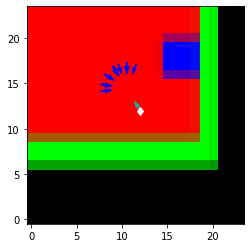

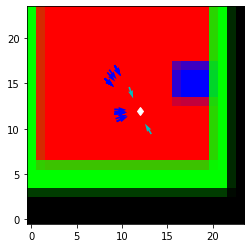

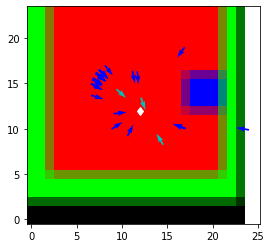

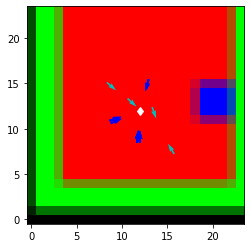

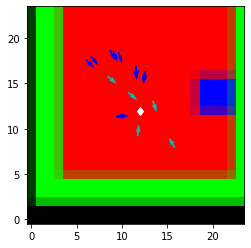

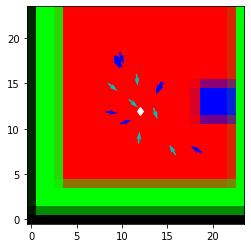

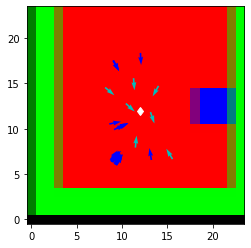

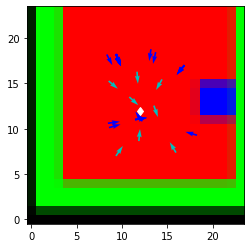

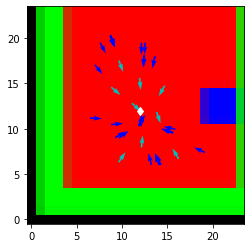

In [12]:
groups_opt, distros_opt, env_opt, exec_times_opt = opt_generate_groups(9, cp_group, cocktail_party_env, 3.0, draw_result=True)

In [13]:
print(exec_times_opt)

[0.570857048034668, 0.8280801773071289, 0.7559287548065186, 3.2212600708007812, 0.8363900184631348, 0.4446558952331543, 0.5963702201843262, 0.5907840728759766, 0.5627901554107666]


# Plotting iterative group generation

In [14]:
def env_cropped_grey(env_cropped, eres=0.25, favor_tall=False):
    offset_x = (env_cropped.shape[1] * 0.5) * eres
    offset_y = (env_cropped.shape[0] * 0.5) * eres
    
    env_np = np.zeros((24,24,3))
    
    env_np[:,:,0] = np.where(env_cropped[:,:,1].detach().numpy() > 0.0, np.ones((24,24)), np.zeros((24,24)))
    env_np[:,:,1] = np.where(env_cropped[:,:,3].detach().numpy() > 0.0, np.ones((24,24)), np.zeros((24,24)))
    env_np[:,:,2] = np.where(env_cropped[:,:,2].detach().numpy() > 0.0, np.ones((24,24)), np.zeros((24,24)))
    
    grayscale_img = np.dot(env_np, [1.0, 2.0, 4.0]) # free, short, tall
    grayscale_img = np.where(grayscale_img == 7.0, np.ones((24,24))*2.0,grayscale_img) # free, short and tall => short
    grayscale_img = np.where(grayscale_img == 6.0, np.ones((24,24))*2.0,grayscale_img) # short and tall => short
    if favor_tall:
        grayscale_img = np.where(grayscale_img == 5.0, np.ones((24,24))*4,grayscale_img) # free and tall => free
    else:
        grayscale_img = np.where(grayscale_img == 5.0, np.ones((24,24)),grayscale_img) # free and tall => free
    grayscale_img = np.where(grayscale_img == 3.0, np.ones((24,24))*2.0,grayscale_img) # free and short => short

    grayscale_img = np.where(grayscale_img == 1.0, np.ones((24,24))*0.92,grayscale_img) # free is lightest grey
    grayscale_img = np.where(grayscale_img == 2.0, np.ones((24,24))*0.75,grayscale_img) # short is light grey
    grayscale_img = np.where(grayscale_img == 4.0, np.ones((24,24))*0.58,grayscale_img) # tall is dark grey
    grayscale_img = np.where(grayscale_img == 0.0, np.ones((24,24))*0.41,grayscale_img) # unknown is darkest grey
    
    return grayscale_img, offset_x, offset_y


# get individual tensor
def make_rect_tensor(input_np):
    input_tensor = torch.from_numpy(input_np)
    out_tensor = torch.zeros((input_tensor.shape[0],4))
    out_tensor[:,0:2] = input_tensor[:,0:2]
    out_tensor[:,2] = torch.cos(input_tensor[:,2])
    out_tensor[:,3] = torch.sin(input_tensor[:,2])
    return out_tensor

In [15]:
def plot_iterative_group(group_lst, distro_lst, env_lst, eres=0.25, favor_tall=False, filename=None):
    fig, axs = plt.subplots(1, 6, figsize=(25,7))

    for i, ax in enumerate(axs):
        if i == 5:
            i = 8
        # get grayscale version of map
        grey_map, off_x, off_y = env_cropped_grey(torch.Tensor(env_lst[i+1]), eres=eres, favor_tall=favor_tall)

        # convert context to rectangular
        plot_context = make_rect_tensor(group_lst[i+1])
        plot_distro = make_rect_tensor(distro_lst[i+1])

        ax.imshow(grey_map, origin='lower', cmap='gray', vmin=0.0, vmax=1.0)
        ax.quiver((off_x + plot_distro[:,0].cpu()) / 0.25,
                  (off_y + plot_distro[:,1].cpu()) / 0.25,
                  plot_distro[:,2].cpu(),
                  plot_distro[:,3].cpu(),
                  color='plum')
        ax.quiver((off_x + plot_context[:, 0].cpu()) / eres,
                     (off_y + plot_context[:, 1].cpu()) / eres,
                     plot_context[:, 2].cpu(),
                     plot_context[:, 3].cpu(),
                     color='darkorange')
        ax.quiver((off_x + plot_context[i+1:,0].cpu()) / eres,
                  (off_y + plot_context[i+1:,1].cpu()) / eres,
                  plot_context[i+1:,2].cpu(),
                  plot_context[i+1:,3].cpu(),
                  color='indigo')
        ax.axis('off')
        ax.set_aspect('equal')

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)

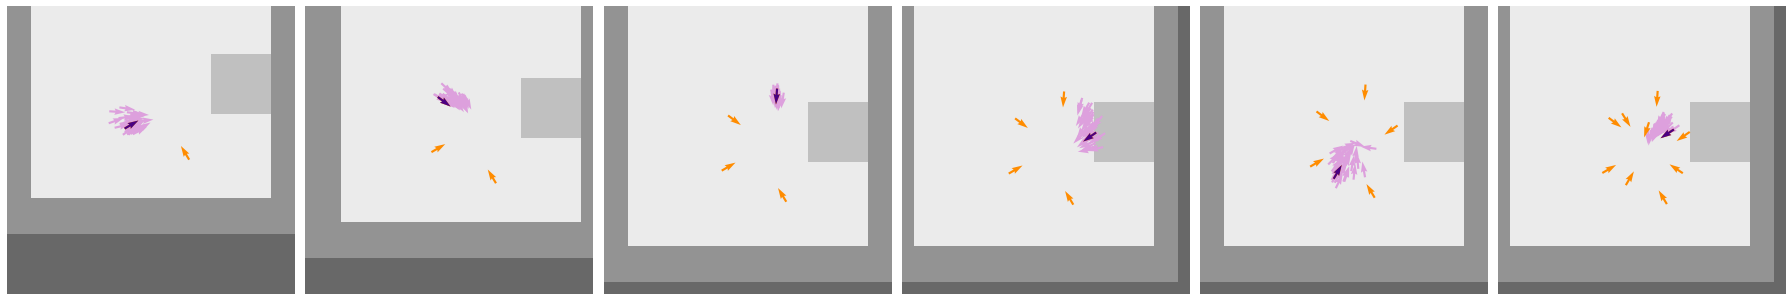

In [16]:
plot_iterative_group(groups_gan, distros_gan, env_gan, eres=0.25, filename='iterative_GAN_CP_6.svg')

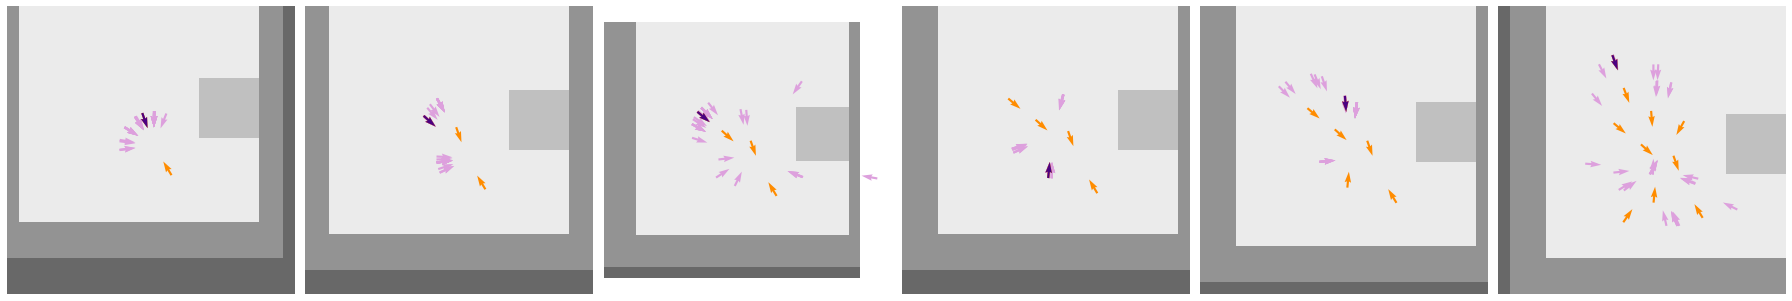

In [17]:
plot_iterative_group(groups_opt, distros_opt, env_opt, eres=0.25, filename='iterative_OPT_CP_6.svg')

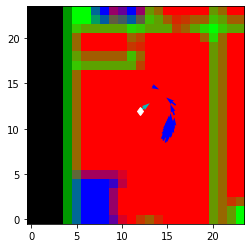

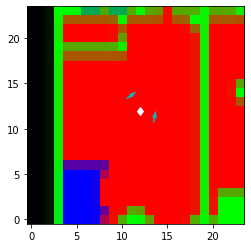

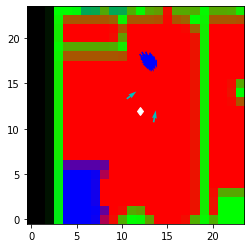

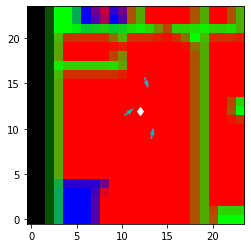

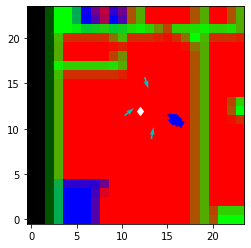

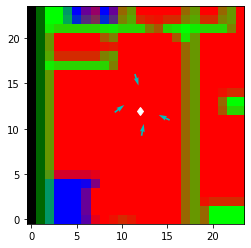

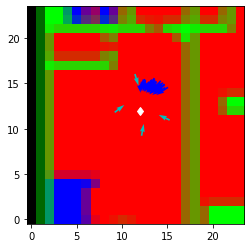

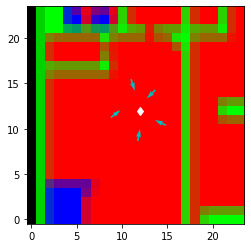

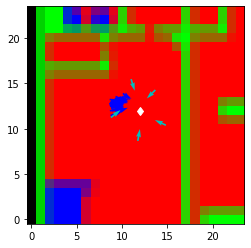

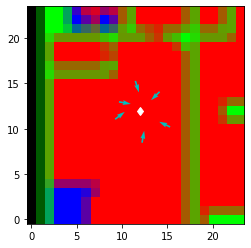

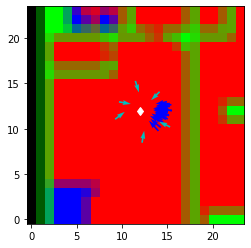

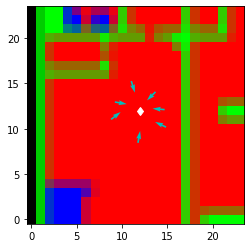

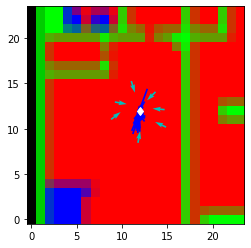

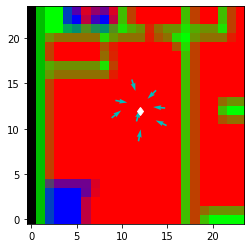

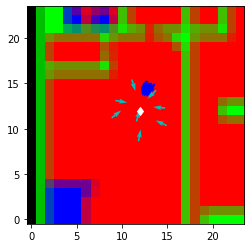

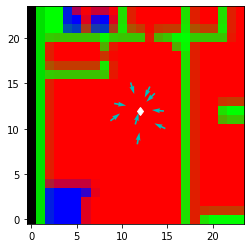

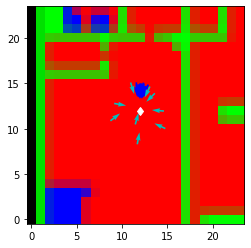

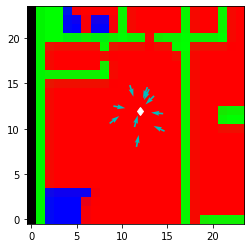

In [18]:
groups_gan_merom, distros_gan_merom, env_gan_merom, exec_times_gan_merom = generate_groups(model, 9, merom_group, merom_env, 3.0, draw_result=True)

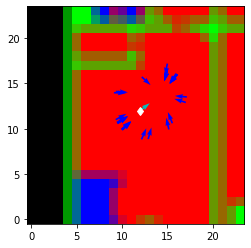

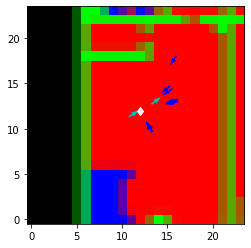

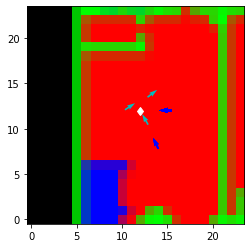

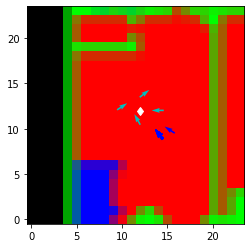

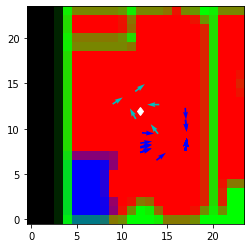

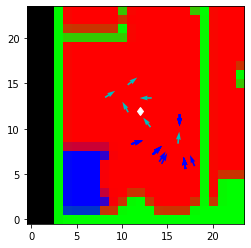

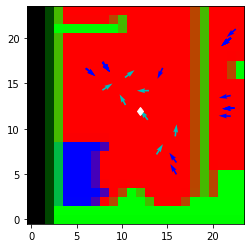

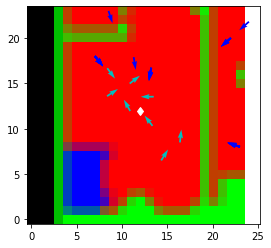

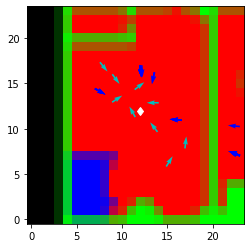

In [19]:
groups_opt_merom, distros_opt_merom, env_opt_merom, exec_times_opt_merom = opt_generate_groups(9, merom_group, merom_env, 3.0, draw_result=True)

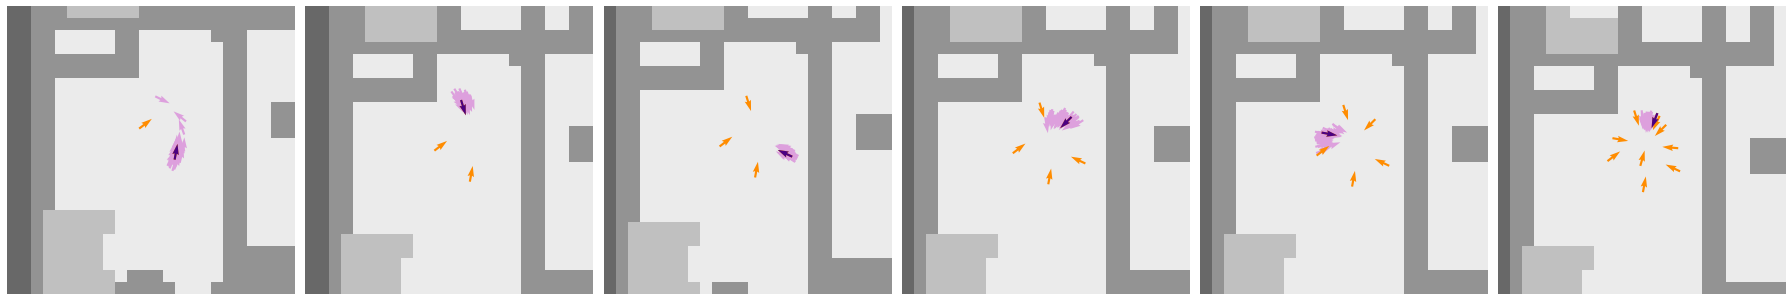

In [20]:
plot_iterative_group(groups_gan_merom, distros_gan_merom, env_gan_merom, eres=0.25, favor_tall=True, filename='iterative_GAN_merom_6.svg')

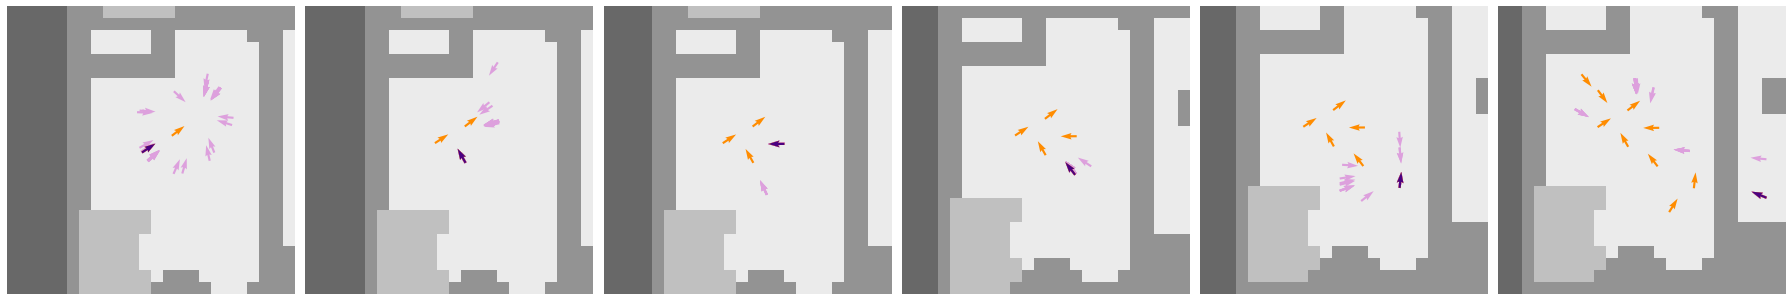

In [21]:
plot_iterative_group(groups_opt_merom, distros_opt_merom, env_opt_merom, eres=0.25, favor_tall=True, filename='iterative_OPT_merom_6.svg')